In [1]:
import tensorflow as tf
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from net.refinenet import RefineNet
%matplotlib inline

inp = tf.placeholder(tf.float32,shape=[None,224,224,4],name='input')
refine_net = RefineNet(inp,'resnet_v1_50','exp/coarse-weighted-f5-5/iters-14000')

net,end_points = refine_net.net,refine_net.end_points
coarse_net_end = end_points['tail/linear2']

# Attach sigmoid and reshape
coarse_out= tf.reshape(tf.sigmoid(coarse_net_end),[-1,56,56,1])
refine_out = tf.sigmoid(net)

sess = tf.InteractiveSession()
refine_net.initialize(sess,'exp/r-coarse-weighted-f5-5-4/iters-6000')
#saver = tf.train.Saver()
#saver.restore(sess, 'exp/test3/iters-20929')

print("Model Loaded")

INFO:tensorflow:Scale of 0 disables regularizer.


2016-10-13 15:05:01,486 - tensorflow - INFO - Scale of 0 disables regularizer.
Model Loaded


In [2]:
from dataprovider.preprocess import vgg_preprocess
import os
from skimage import transform
from dataprovider.davis import DataAccessHelper
import numpy as np
BASE_DIR = os.path.join('/work/george','DAVIS')
IMAGESETS = os.path.join('ImageSets','480p')
    
RESIZE_HEIGHT = 224
RESIZE_WIDTH = 224
helper = DataAccessHelper()
def read_image(imageFile,prevMaskFile):
               
    # Read images 
    rgb = helper.read_image(imageFile)
    mask = helper.read_label(prevMaskFile)
    mask = np.expand_dims(mask,axis=2)
        
    # Concatenate images
    image =  np.concatenate((rgb, mask), 2)
    
    # Resize 
    image = transform.resize(image,[RESIZE_HEIGHT,RESIZE_WIDTH])
       
    #io.imshow(image[:,:,0:3])  
    print('Max',image.max(),image.min())
    image = image*255
    #plt.imshow(image[:,:,0:3].astype(np.uint8)) 
    
    
    image = np.expand_dims(image,axis=0)
    
    image = vgg_preprocess(image)
    
    return image


test_img = ['JPEGImages/480p/bear/00004.jpg' ,'Annotations/480p/bear/00003.png']
v = read_image(test_img[0],test_img[1])

/work/george/DAVIS/Annotations/480p/bear/00003.png
2016-10-13 15:05:09,027 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:05:09,028 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2880
Max 1.0 0.0


/work/george/DAVIS/Annotations/480p/bear/00003.png
2016-10-13 15:08:42,086 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:08:42,087 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2880
Max 1.0 0.0
/work/george/DAVIS/Annotations/480p/bear/00003.png
2016-10-13 15:08:42,117 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:08:42,118 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2880
/work/george/DAVIS/Annotations/480p/bear/00004.png
2016-10-13 15:08:42,332 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:08:42,334 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2862
/work/george/DAVIS/Annotations/480p/bear/00003.png
2016-10-13 15:08:42,461 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:08:42,461 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2880
/work/george/DAVIS/Annotations/480p/bear/00004.png
2016-10-13 15:08:42,469 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-13 15:08:42,469 - PIL.PngImagePlu

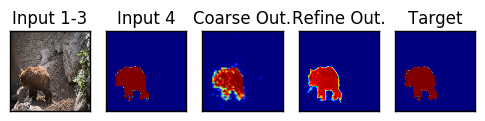

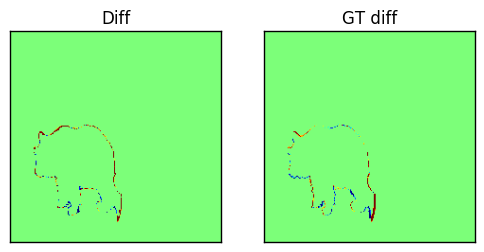

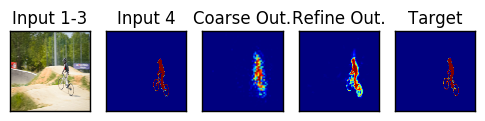

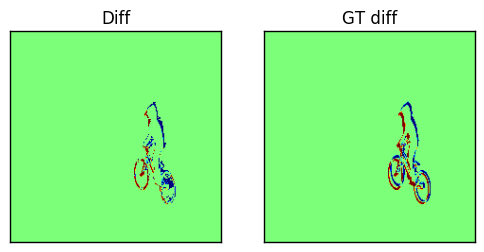

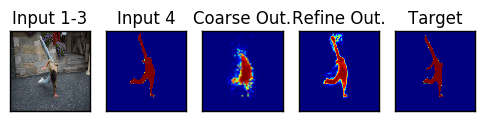

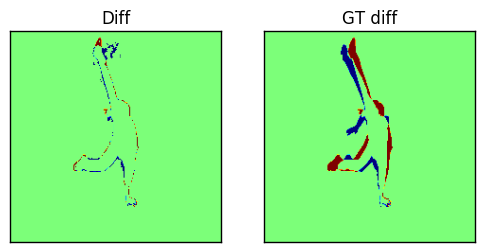

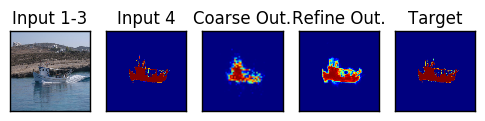

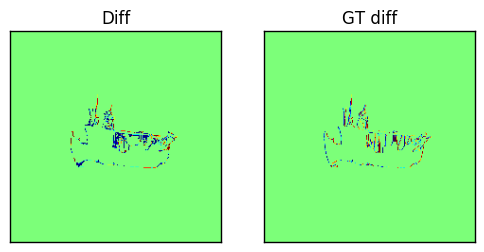

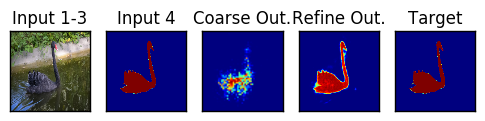

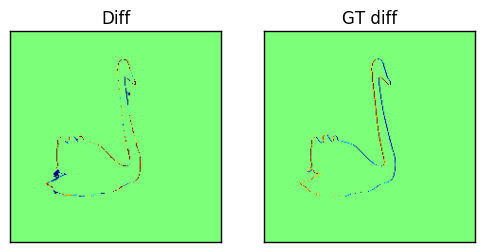

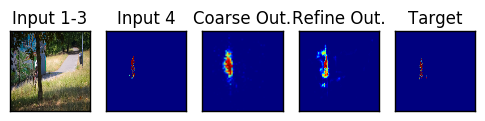

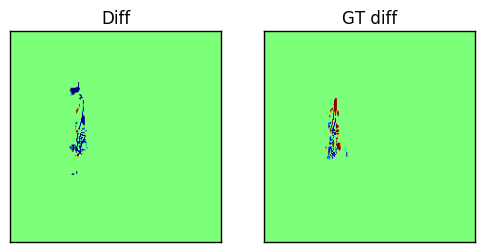

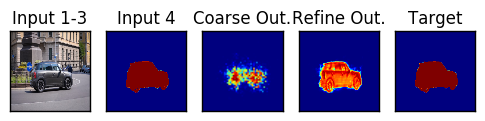

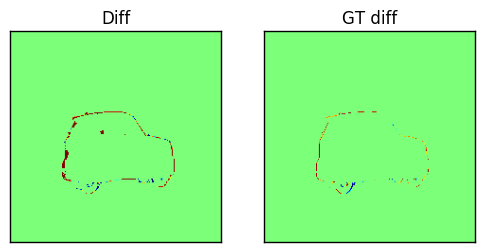

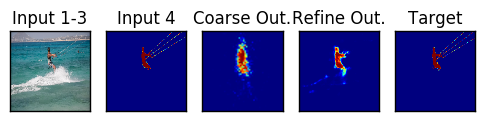

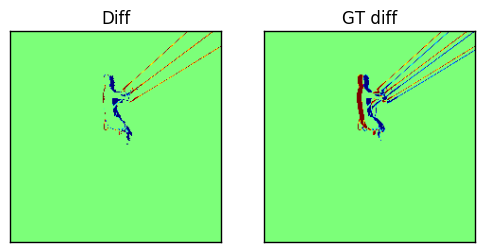

In [4]:
from skimage import morphology
from dataprovider.davis import DataAccessHelper

img_list = [['JPEGImages/480p/bear/00004.jpg' ,'Annotations/480p/bear/00003.png'],
['JPEGImages/480p/bmx-bumps/00086.jpg' ,'Annotations/480p/bmx-bumps/00085.png'],
           ['JPEGImages/480p/breakdance-flare/00003.jpg', 'Annotations/480p/breakdance-flare/00002.png'],
           ['JPEGImages/480p/boat/00008.jpg','Annotations/480p/boat/00007.png' ],
           ['JPEGImages/480p/blackswan/00007.jpg', 'Annotations/480p/blackswan/00006.png' ],
           ['JPEGImages/480p/bmx-trees/00066.jpg', 'Annotations/480p/bmx-trees/00065.png' ],
           ['JPEGImages/480p/car-roundabout/00042.jpg', 'Annotations/480p/car-roundabout/00041.png' ],
           ['JPEGImages/480p/kite-surf/00034.jpg', 'Annotations/480p/kite-surf/00033.png' ]]

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127

davis = DataAccessHelper()

for image_no in range(len(img_list)):

    image_path = img_list[image_no][0]
    prev_label_path = img_list[image_no][1]
    
    label_path = davis.construct_label_path(image_path)
    image = read_image(image_path,prev_label_path)
    prev_label_img = davis.read_label(prev_label_path,[224,224])
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))

    result = sess.run([coarse_out,refine_out],feed_dict={inp:image})

    coarse_mask = result[0][0,:,:,0]
    refine_mask = result[1][0,:,:,0]

    plt.figure()

    plot_rows = 1
    plot_cols = 5
    
    #Plot input image
    plt.subplot(plot_rows,plot_cols,1)
    frame1 = plt.gca()
    frame1.axes.set_title('Input 1-3')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    rgb = image[0,:,:,0:3]
    #print(rgb.shape)
    means = [_R_MEAN, _G_MEAN ,_B_MEAN]
    rgb = rgb + means
    plt.imshow(rgb.astype(np.uint8))

    #Plot previous label
    plt.subplot(plot_rows,plot_cols,2)
    
    frame1 = plt.gca()
    frame1.axes.set_title('Input 4')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(image[0,:,:,3])

    #Plot output
    plt.subplot(plot_rows,plot_cols,3)
    frame1 = plt.gca()
    frame1.axes.set_title('Coarse Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(coarse_mask)
    
    #Plot output
    plt.subplot(plot_rows,plot_cols,4)
    frame1 = plt.gca()
    frame1.axes.set_title('Refine Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(refine_mask)
    
    
    #Plot label
    
    label_img = davis.read_label(label_path,[224,224])
    
    plt.subplot(plot_rows,plot_cols,5)
    frame1 = plt.gca()
    frame1.axes.set_title('Target')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(label_img)
    
    plt.figure()
    
    # Plot diff
    plt.subplot(1,2,1)
    refine_mask_thresh = refine_mask
    threshold = 0.5
    refine_mask_thresh[refine_mask_thresh<threshold]=0
    refine_mask_thresh[refine_mask_thresh>=threshold]=1
    diff_ref= prev_label_img - refine_mask
    frame1 = plt.gca()
    frame1.axes.set_title('Diff')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(diff_ref)
    
    # Plot GT diff
    plt.subplot(1,2,2)
    diff_img=davis.diff_labels(prev_label_path,label_path,[224,224])
    frame1 = plt.gca()
    frame1.axes.set_title('GT diff')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(diff_img)

    